<a href="https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/intro_logging.ipynb" 
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Investigate an agents api calls, set seeds and fix juypter output cell clearing issues

### Install packages (gym, tfagents, tensorflow,....)

#### suppress package warnings, in colab: load additional packages for rendering

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import warnings

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get update >/dev/null
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 
else:
    #  for local installation
    sys.path.append('..')

#### install easyagents

In [2]:
import sys
if 'google.colab' in sys.modules:
    !pip install easyagents >/dev/null    

## Agent logging 

Use the log.Agent() callback to investigate how easyagents interacts with a backend:

In [3]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import duration, log

ppoAgent = PpoAgent('CartPole-v0')
ppoAgent.train([log.Agent(), duration.Fast()], default_plots=False)

backend_name             tfagents 
TFPyEnvironment          ( suite_gym.load( "CartPole-v0", discount=1.0) ) 
AdamOptimizer            () 
ActorDistributionNetwork () 
ValueNetwork             () 
PpoAgent                 () 
tf_agent.initialize      () 
TFUniformReplayBuffer    () 
DynamicEpisodeDriver     () 
TFPyEnvironment          ( suite_gym.load( "CartPole-v0", discount=1) ) 
-----                    iteration    0 of 10        ----- 
collect_driver.run       () 
replay_buffer.gather_all () 
tf_agent.train           (experience=...) 
                         loss=4509.4  [actor=0.1     critic=4509.3 ] 
replay_buffer.clear      () 
-----                    iteration    1 of 10        ----- 
collect_driver.run       () 
replay_buffer.gather_all () 
tf_agent.train           (experience=...) 
                         loss=4121.6  [actor=0.1     critic=4121.5 ] 
replay_buffer.clear      () 
-----                    iteration    2 of 10        ----- 
collect_driver.run       () 
repla

<Figure size 1224x432 with 0 Axes>

Plots clear the jupyter cell ouput before each update thereby clearing the log output as well, thus we turned them off.
Typically each call to the backend api during training is logged. 
Note that the logging starts with 'tfagents' the default backend for the PpoAgent.
We then see a sequence of calls performing the Agent initialisation before we enter the train loop.
Api calls during play or evaluation are not logged.

Let's take a look at the tensorforce backend:

**tensorforce and keras are suspended pending tensorflow 2.0 support**

In [4]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import duration, log

#ppoAgent = PpoAgent('CartPole-v0', backend='tensorforce')
#ppoAgent.train([log.Agent(), duration.Fast()], default_plots=False)

While in tensorforce we also first do a sequence of agent and policy. Note that in contrast to tfagents we do not
build up actor and critic policy networks but instead pass a network specification to the Agent.create call.
Moreover tensorforce implements already the train loop through its Runner class. 
Thus we only see 1 call to runner.run instead of the many api calls for tfagents.

## Seeding

To set a seed use:

In [5]:
import easyagents

easyagents.agents.seed = 0

Once set, the seed is applied before each call to train. Let's validate this using our log.Agent callback:

In [6]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import duration, log

ppoAgent = PpoAgent('CartPole-v0')
ppoAgent.train([log.Agent(), duration.Fast()], default_plots=False)

backend_name             tfagents 
tf.random.set_seed       (seed=0) 
numpy.random.seed        (0) 
random.seed              (0) 
TFPyEnvironment          ( suite_gym.load( "CartPole-v0", discount=1.0) ) 
AdamOptimizer            () 
ActorDistributionNetwork () 
ValueNetwork             () 
PpoAgent                 () 
tf_agent.initialize      () 
TFUniformReplayBuffer    () 
DynamicEpisodeDriver     () 
TFPyEnvironment          ( suite_gym.load( "CartPole-v0", discount=1) ) 
-----                    iteration    0 of 10        ----- 
collect_driver.run       () 
replay_buffer.gather_all () 
tf_agent.train           (experience=...) 
                         loss=8528.5  [actor=0.0     critic=8528.5 ] 
replay_buffer.clear      () 
-----                    iteration    1 of 10        ----- 
collect_driver.run       () 
replay_buffer.gather_all () 
tf_agent.train           (experience=...) 
                         loss=5304.3  [actor=0.1     critic=5304.3 ] 
replay_buffer.clear      () 

<Figure size 1224x432 with 0 Axes>

Note that at the very beginning the calls to set the seeds for tensorflow, numpy and python.

## Iteration & Duration logging
Use the log.Iteration() callback to log the training progress:

In [7]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import duration, log

ppoAgent = PpoAgent('CartPole-v0')
ppoAgent.train([log.Iteration(), duration.Fast()], default_plots=False)

iteration 0  of 10       episodes_done=0   steps_done=0     rewards=(50.0,50.0,50.0) steps=(50.0,50.0,50.0) 
iteration 1  of 10       episodes_done=3   steps_done=59    loss=8528.5  [actor=0.0     critic=8528.5 ] 
iteration 2  of 10       episodes_done=6   steps_done=114   loss=5304.3  [actor=0.1     critic=5304.3 ] 
iteration 3  of 10       episodes_done=9   steps_done=178   loss=8645.1  [actor=0.0     critic=8645.0 ] 
iteration 4  of 10       episodes_done=12  steps_done=244   loss=9818.4  [actor=0.0     critic=9818.3 ] rewards=(50.0,50.0,50.0) steps=(50.0,50.0,50.0) 
iteration 5  of 10       episodes_done=15  steps_done=288   loss=4630.6  [actor=0.1     critic=4630.6 ] 
iteration 6  of 10       episodes_done=18  steps_done=361   loss=11265.8 [actor=0.0     critic=11265.8] 
iteration 7  of 10       episodes_done=21  steps_done=476   loss=26230.5 [actor=0.0     critic=26230.4] 
iteration 8  of 10       episodes_done=24  steps_done=526   loss=5172.6  [actor=0.0     critic=5172.6 ] rewa

<Figure size 1224x432 with 0 Axes>

The first line shows the result of an initial policy evaluation depicting the policy's performance before any 
training has happend. Policy evaluation happens every `num_iterations_between_eval` iterations and spans over
`num_episodes_per_eval` episodes. For every evaluation period the result is logged again. The `steps_done`value is 
the number of training steps (excluding the steps taken during evaluation). 
To see the training duration configuration use the log.Duration() callback:

In [8]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import duration, log

ppoAgent = PpoAgent('CartPole-v0')
ppoAgent.train([log.Duration(), duration.Fast()], default_plots=False)

duration                 num_iterations=100 num_episodes_per_iteration=10 num_max_steps_per_episode=500 num_iterations_between_plot=2 num_iterations_between_eval=5 num_episodes_per_eval=10 


<Figure size 1224x432 with 0 Axes>

## Gym steps logging
Use the log.Step() callback to investigate how the agent interacts with the gym environment:

In [9]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import duration, log

ppoAgent = PpoAgent('CartPole-v0')
ppoAgent.train([log.Step(), duration.Fast()], default_plots=False)

[CartPole-v0 9:0  :1  ] train iteration=0  step=0   play  episode=0  step=1     sum_of_rewards=1.0     reward=1.0   done=False action=1 observation=[-0.04363321  0.24146826  0.01284913 -0.30946528]
[CartPole-v0 9:0  :2  ] train iteration=0  step=0   play  episode=0  step=2     sum_of_rewards=2.0     reward=1.0   done=False action=0 observation=[-0.03880385  0.04616562  0.00665982 -0.01275795]
[CartPole-v0 9:0  :3  ] train iteration=0  step=0   play  episode=0  step=3     sum_of_rewards=3.0     reward=1.0   done=False action=1 observation=[-0.03788053  0.24119143  0.00640466 -0.30333221]
[CartPole-v0 9:0  :4  ] train iteration=0  step=0   play  episode=0  step=4     sum_of_rewards=4.0     reward=1.0   done=False action=0 observation=[-0.03305671  0.04597879  0.00033802 -0.0086363 ]
[CartPole-v0 9:0  :5  ] train iteration=0  step=0   play  episode=0  step=5     sum_of_rewards=5.0     reward=1.0   done=False action=1 observation=[-3.21371306e-02  2.41095889e-01  1.65294467e-04 -3.01212554

[CartPole-v0 9:0  :43 ] train iteration=0  step=0   play  episode=0  step=43    sum_of_rewards=43.0    reward=1.0   done=False action=0 observation=[-1.12964693e-03 -1.49404829e-01  2.04017434e-04  2.89818605e-01]
[CartPole-v0 9:0  :44 ] train iteration=0  step=0   play  episode=0  step=44    sum_of_rewards=44.0    reward=1.0   done=False action=1 observation=[-0.00411774  0.04571421  0.00600039 -0.00279997]
[CartPole-v0 9:0  :45 ] train iteration=0  step=0   play  episode=0  step=45    sum_of_rewards=45.0    reward=1.0   done=False action=1 observation=[-0.00320346  0.2407496   0.00594439 -0.29358368]
[CartPole-v0 9:0  :46 ] train iteration=0  step=0   play  episode=0  step=46    sum_of_rewards=46.0    reward=1.0   done=False action=0 observation=[1.61153266e-03 4.55434012e-02 7.27166229e-05 9.68084346e-04]
[CartPole-v0 9:0  :47 ] train iteration=0  step=0   play  episode=0  step=47    sum_of_rewards=47.0    reward=1.0   done=False action=1 observation=[ 2.52240068e-03  2.40664309e-01

[CartPole-v0 9:1  :35 ] train iteration=0  step=0   play  episode=1  step=35    sum_of_rewards=35.0    reward=1.0   done=False action=1 observation=[-0.02762745 -0.16010519 -0.07933344 -0.08122918]
[CartPole-v0 9:1  :36 ] train iteration=0  step=0   play  episode=1  step=36    sum_of_rewards=36.0    reward=1.0   done=False action=0 observation=[-0.03082955 -0.35400555 -0.08095803  0.18540699]
[CartPole-v0 9:1  :37 ] train iteration=0  step=0   play  episode=1  step=37    sum_of_rewards=37.0    reward=1.0   done=False action=1 observation=[-0.03790966 -0.1578242  -0.07724989 -0.13167687]
[CartPole-v0 9:1  :38 ] train iteration=0  step=0   play  episode=1  step=38    sum_of_rewards=38.0    reward=1.0   done=False action=0 observation=[-0.04106615 -0.35175947 -0.07988342  0.1356696 ]
[CartPole-v0 9:1  :39 ] train iteration=0  step=0   play  episode=1  step=39    sum_of_rewards=39.0    reward=1.0   done=False action=1 observation=[-0.04810133 -0.15558958 -0.07717003 -0.18110763]
[CartPole-

[CartPole-v0 9:2  :27 ] train iteration=0  step=0   play  episode=2  step=27    sum_of_rewards=27.0    reward=1.0   done=False action=1 observation=[-0.080389   -0.17102392 -0.06824292 -0.13192664]
[CartPole-v0 9:2  :28 ] train iteration=0  step=0   play  episode=2  step=28    sum_of_rewards=28.0    reward=1.0   done=False action=0 observation=[-0.08380947 -0.36510533 -0.07088145  0.13846999]
[CartPole-v0 9:2  :29 ] train iteration=0  step=0   play  episode=2  step=29    sum_of_rewards=29.0    reward=1.0   done=False action=1 observation=[-0.09111158 -0.16904352 -0.06811205 -0.17570595]
[CartPole-v0 9:2  :30 ] train iteration=0  step=0   play  episode=2  step=30    sum_of_rewards=30.0    reward=1.0   done=False action=0 observation=[-0.09449245 -0.36312793 -0.07162617  0.09473616]
[CartPole-v0 9:2  :31 ] train iteration=0  step=0   play  episode=2  step=31    sum_of_rewards=31.0    reward=1.0   done=False action=1 observation=[-0.10175501 -0.16705637 -0.06973145 -0.21965717]
[CartPole-

[CartPole-v0 8:1  :8  ] train iteration=0  step=25   reward=1.0   done=False action=0 observation=[-0.02906193  0.01913484 -0.02228046 -0.02332929]
[CartPole-v0 8:1  :9  ] train iteration=0  step=26   reward=1.0   done=False action=1 observation=[-0.02867924  0.21456911 -0.02274705 -0.32295785]
[CartPole-v0 8:1  :10 ] train iteration=0  step=27   reward=1.0   done=False action=1 observation=[-0.02438785  0.41000746 -0.0292062  -0.62272659]
[CartPole-v0 8:1  :11 ] train iteration=0  step=28   reward=1.0   done=False action=0 observation=[-0.01618771  0.21530523 -0.04166074 -0.3393832 ]
[CartPole-v0 8:1  :12 ] train iteration=0  step=29   reward=1.0   done=False action=1 observation=[-0.0118816   0.41099445 -0.0484484  -0.64490705]
[CartPole-v0 8:1  :13 ] train iteration=0  step=30   reward=1.0   done=False action=0 observation=[-0.00366171  0.21657994 -0.06134654 -0.36786574]
[CartPole-v0 8:1  :14 ] train iteration=0  step=31   reward=1.0   done=False action=0 observation=[ 0.00066989  

[CartPole-v0 8:4  :6  ] train iteration=1  step=22   reward=1.0   done=False action=1 observation=[ 0.03410704 -0.04687147 -0.02365146 -0.01503955]
[CartPole-v0 8:4  :7  ] train iteration=1  step=23   reward=1.0   done=False action=1 observation=[ 0.03316961  0.14858155 -0.02395225 -0.31508996]
[CartPole-v0 8:4  :8  ] train iteration=1  step=24   reward=1.0   done=False action=1 observation=[ 0.03614124  0.34403635 -0.03025405 -0.61522936]
[CartPole-v0 8:4  :9  ] train iteration=1  step=25   reward=1.0   done=False action=1 observation=[ 0.04302197  0.53956767 -0.04255864 -0.91728544]
[CartPole-v0 8:4  :10 ] train iteration=1  step=26   reward=1.0   done=False action=0 observation=[ 0.05381332  0.34504617 -0.06090435 -0.63827587]
[CartPole-v0 8:4  :11 ] train iteration=1  step=27   reward=1.0   done=False action=0 observation=[ 0.06071425  0.15082398 -0.07366987 -0.36537755]
[CartPole-v0 8:4  :12 ] train iteration=1  step=28   reward=1.0   done=False action=1 observation=[ 0.06373073  

[CartPole-v0 8:6  :23 ] train iteration=2  step=23   reward=1.0   done=False action=0 observation=[-0.08520556 -0.94193243  0.14861922  1.6158365 ]
[CartPole-v0 8:6  :24 ] train iteration=2  step=24   reward=1.0   done=False action=0 observation=[-0.10404421 -1.13846208  0.18093595  1.95091468]
[CartPole-v0 8:7  :25 ] train iteration=2  step=25   reward=1.0   done=True  action=0 observation=[-0.12681345 -1.3349888   0.21995424  2.29379792]
[CartPole-v0 8:7  :1  ] train iteration=2  step=26   reward=1.0   done=False action=0 observation=[ 0.0404217  -0.21039115 -0.0010204   0.26814947]
[CartPole-v0 8:7  :2  ] train iteration=2  step=27   reward=1.0   done=False action=1 observation=[ 0.03621387 -0.01525465  0.00434259 -0.02485513]
[CartPole-v0 8:7  :3  ] train iteration=2  step=28   reward=1.0   done=False action=1 observation=[ 0.03590878  0.17980475  0.00384548 -0.31616476]
[CartPole-v0 8:7  :4  ] train iteration=2  step=29   reward=1.0   done=False action=1 observation=[ 0.03950488  

[CartPole-v0 8:9  :15 ] train iteration=3  step=15   reward=1.0   done=False action=0 observation=[ 0.02276152 -0.52617938 -0.1025752   0.45477972]
[CartPole-v0 8:9  :16 ] train iteration=3  step=16   reward=1.0   done=False action=1 observation=[ 0.01223793 -0.32976799 -0.0934796   0.13160696]
[CartPole-v0 8:9  :17 ] train iteration=3  step=17   reward=1.0   done=False action=0 observation=[ 0.00564257 -0.52343521 -0.09084746  0.39339646]
[CartPole-v0 8:9  :18 ] train iteration=3  step=18   reward=1.0   done=False action=1 observation=[-0.00482613 -0.32714944 -0.08297953  0.07350953]
[CartPole-v0 8:9  :19 ] train iteration=3  step=19   reward=1.0   done=False action=0 observation=[-0.01136912 -0.5209898  -0.08150934  0.33890162]
[CartPole-v0 8:9  :20 ] train iteration=3  step=20   reward=1.0   done=False action=1 observation=[-0.02178892 -0.32480834 -0.07473131  0.0216692 ]
[CartPole-v0 8:9  :21 ] train iteration=3  step=21   reward=1.0   done=False action=0 observation=[-0.02828509 -

[CartPole-v0 9:3  :4  ] train iteration=4  step=66  play  episode=0  step=4     sum_of_rewards=4.0     reward=1.0   done=False action=0 observation=[0.00505916 0.01052759 0.03627014 0.07371844]
[CartPole-v0 9:3  :5  ] train iteration=4  step=66  play  episode=0  step=5     sum_of_rewards=5.0     reward=1.0   done=False action=1 observation=[ 0.00526972  0.2051113   0.0377445  -0.20730408]
[CartPole-v0 9:3  :6  ] train iteration=4  step=66  play  episode=0  step=6     sum_of_rewards=6.0     reward=1.0   done=False action=0 observation=[0.00937194 0.00947052 0.03359842 0.09704233]
[CartPole-v0 9:3  :7  ] train iteration=4  step=66  play  episode=0  step=7     sum_of_rewards=7.0     reward=1.0   done=False action=1 observation=[ 0.00956135  0.20409522  0.03553927 -0.18485388]
[CartPole-v0 9:3  :8  ] train iteration=4  step=66  play  episode=0  step=8     sum_of_rewards=8.0     reward=1.0   done=False action=0 observation=[0.01364326 0.00848327 0.03184219 0.11882511]
[CartPole-v0 9:3  :9  

[CartPole-v0 9:3  :46 ] train iteration=4  step=66  play  episode=0  step=46    sum_of_rewards=46.0    reward=1.0   done=False action=0 observation=[0.15483218 0.3636669  0.11859306 0.30887355]
[CartPole-v0 9:3  :47 ] train iteration=4  step=66  play  episode=0  step=47    sum_of_rewards=47.0    reward=1.0   done=False action=1 observation=[0.16210552 0.55691703 0.12477053 0.05581911]
[CartPole-v0 9:3  :48 ] train iteration=4  step=66  play  episode=0  step=48    sum_of_rewards=48.0    reward=1.0   done=False action=0 observation=[0.17324386 0.36024744 0.12588692 0.38511763]
[CartPole-v0 9:3  :49 ] train iteration=4  step=66  play  episode=0  step=49    sum_of_rewards=49.0    reward=1.0   done=False action=1 observation=[0.18044881 0.5533784  0.13358927 0.13462672]
[CartPole-v0 9:4  :50 ] train iteration=4  step=66  play  episode=0  step=50    sum_of_rewards=50.0    reward=1.0   done=True  action=1 observation=[ 0.19151637  0.74635906  0.1362818  -0.11310661]
[CartPole-v0 9:4  :1  ] tr

[CartPole-v0 9:4  :38 ] train iteration=4  step=66  play  episode=1  step=38    sum_of_rewards=38.0    reward=1.0   done=False action=0 observation=[-0.04018258 -0.32572575 -0.07927688  0.09312462]
[CartPole-v0 9:4  :39 ] train iteration=4  step=66  play  episode=1  step=39    sum_of_rewards=39.0    reward=1.0   done=False action=1 observation=[-0.0466971  -0.1295623  -0.07741439 -0.2234794 ]
[CartPole-v0 9:4  :40 ] train iteration=4  step=66  play  episode=1  step=40    sum_of_rewards=40.0    reward=1.0   done=False action=0 observation=[-0.04928834 -0.32349734 -0.08188397  0.04381481]
[CartPole-v0 9:4  :41 ] train iteration=4  step=66  play  episode=1  step=41    sum_of_rewards=41.0    reward=1.0   done=False action=1 observation=[-0.05575829 -0.12730249 -0.08100768 -0.2735384 ]
[CartPole-v0 9:4  :42 ] train iteration=4  step=66  play  episode=1  step=42    sum_of_rewards=42.0    reward=1.0   done=False action=0 observation=[-0.05830434 -0.32118077 -0.08647845 -0.00746489]
[CartPole-

[CartPole-v0 9:5  :30 ] train iteration=4  step=66  play  episode=2  step=30    sum_of_rewards=30.0    reward=1.0   done=False action=1 observation=[-0.00844769 -0.02850533 -0.06986319 -0.42110001]
[CartPole-v0 9:5  :31 ] train iteration=4  step=66  play  episode=2  step=31    sum_of_rewards=31.0    reward=1.0   done=False action=0 observation=[-0.0090178  -0.22257147 -0.07828519 -0.15123398]
[CartPole-v0 9:5  :32 ] train iteration=4  step=66  play  episode=2  step=32    sum_of_rewards=32.0    reward=1.0   done=False action=0 observation=[-0.01346923 -0.41649025 -0.08130987  0.11576096]
[CartPole-v0 9:5  :33 ] train iteration=4  step=66  play  episode=2  step=33    sum_of_rewards=33.0    reward=1.0   done=False action=1 observation=[-0.02179903 -0.22030308 -0.07899465 -0.2014263 ]
[CartPole-v0 9:5  :34 ] train iteration=4  step=66  play  episode=2  step=34    sum_of_rewards=34.0    reward=1.0   done=False action=0 observation=[-0.02620509 -0.41421161 -0.08302318  0.06532916]
[CartPole-

[CartPole-v0 8:13 :20 ] train iteration=4  step=29   reward=1.0   done=False action=0 observation=[ 0.1249858   0.04814739 -0.1982746  -0.50054844]
[CartPole-v0 8:13 :21 ] train iteration=4  step=30   reward=1.0   done=False action=0 observation=[ 0.12594875 -0.14370842 -0.20828557 -0.27631456]
[CartPole-v0 8:14 :22 ] train iteration=4  step=31   reward=1.0   done=True  action=1 observation=[ 0.12307458  0.05368203 -0.21381186 -0.62679504]
[CartPole-v0 8:14 :1  ] train iteration=4  step=32   reward=1.0   done=False action=1 observation=[-0.047718    0.1816533  -0.00634079 -0.29623005]
[CartPole-v0 8:14 :2  ] train iteration=4  step=33   reward=1.0   done=False action=0 observation=[-0.04408493 -0.01337768 -0.01226539 -0.00555363]
[CartPole-v0 8:14 :3  ] train iteration=4  step=34   reward=1.0   done=False action=0 observation=[-0.04435249 -0.2083216  -0.01237646  0.28323432]
[CartPole-v0 8:14 :4  ] train iteration=4  step=35   reward=1.0   done=False action=1 observation=[-0.04851892 -

[CartPole-v0 8:16 :5  ] train iteration=5  step=41   reward=1.0   done=False action=1 observation=[ 0.01401994  0.20535028 -0.00128872 -0.26949835]
[CartPole-v0 8:16 :6  ] train iteration=5  step=42   reward=1.0   done=False action=1 observation=[ 0.01812694  0.40049059 -0.00667869 -0.56258747]
[CartPole-v0 8:16 :7  ] train iteration=5  step=43   reward=1.0   done=False action=1 observation=[ 0.02613676  0.59570562 -0.01793044 -0.85736701]
[CartPole-v0 8:16 :8  ] train iteration=5  step=44   reward=1.0   done=False action=0 observation=[ 0.03805087  0.40083249 -0.03507778 -0.57037556]
[CartPole-v0 8:16 :9  ] train iteration=5  step=45   reward=1.0   done=False action=0 observation=[ 0.04606752  0.20621958 -0.04648529 -0.28894652]
[CartPole-v0 8:16 :10 ] train iteration=5  step=46   reward=1.0   done=False action=1 observation=[ 0.05019191  0.40197252 -0.05226422 -0.5959205 ]
[CartPole-v0 8:16 :11 ] train iteration=5  step=47   reward=1.0   done=False action=0 observation=[ 0.05823136  

[CartPole-v0 8:18 :24 ] train iteration=6  step=24   reward=1.0   done=False action=1 observation=[-0.02820366 -1.11835406 -0.01956708  1.26735308]
[CartPole-v0 8:18 :25 ] train iteration=6  step=25   reward=1.0   done=False action=0 observation=[-0.05057074 -1.31322066  0.00577998  1.55384468]
[CartPole-v0 8:18 :26 ] train iteration=6  step=26   reward=1.0   done=False action=1 observation=[-0.07683516 -1.11816847  0.03685687  1.26297057]
[CartPole-v0 8:18 :27 ] train iteration=6  step=27   reward=1.0   done=False action=1 observation=[-0.09919853 -0.92353661  0.06211628  0.98205453]
[CartPole-v0 8:18 :28 ] train iteration=6  step=28   reward=1.0   done=False action=1 observation=[-0.11766926 -0.72929957  0.08175737  0.70951132]
[CartPole-v0 8:18 :29 ] train iteration=6  step=29   reward=1.0   done=False action=1 observation=[-0.13225525 -0.53539944  0.0959476   0.44364253]
[CartPole-v0 8:18 :30 ] train iteration=6  step=30   reward=1.0   done=False action=1 observation=[-0.14296324 -

[CartPole-v0 8:19 :30 ] train iteration=6  step=80   reward=1.0   done=False action=0 observation=[ 0.01137431 -0.38698362 -0.1290119   0.09389862]
[CartPole-v0 8:19 :31 ] train iteration=6  step=81   reward=1.0   done=False action=1 observation=[ 0.00363464 -0.19027126 -0.12713393 -0.23654213]
[CartPole-v0 8:19 :32 ] train iteration=6  step=82   reward=1.0   done=False action=0 observation=[-1.70785535e-04 -3.83369290e-01 -1.31864775e-01  1.34905062e-02]
[CartPole-v0 8:19 :33 ] train iteration=6  step=83   reward=1.0   done=False action=0 observation=[-0.00783817 -0.57637783 -0.13159497  0.2618339 ]
[CartPole-v0 8:19 :34 ] train iteration=6  step=84   reward=1.0   done=False action=0 observation=[-0.01936573 -0.76939983 -0.12635829  0.51028621]
[CartPole-v0 8:19 :35 ] train iteration=6  step=85   reward=1.0   done=False action=1 observation=[-0.03475372 -0.57274549 -0.11615256  0.1806059 ]
[CartPole-v0 8:19 :36 ] train iteration=6  step=86   reward=1.0   done=False action=0 observatio

[CartPole-v0 8:21 :21 ] train iteration=7  step=21   reward=1.0   done=False action=1 observation=[-0.09490322 -0.57683682  0.15948557  1.16408064]
[CartPole-v0 8:21 :22 ] train iteration=7  step=22   reward=1.0   done=False action=0 observation=[-0.10643996 -0.77363432  0.18276718  1.50222081]
[CartPole-v0 8:22 :23 ] train iteration=7  step=23   reward=1.0   done=True  action=1 observation=[-0.12191264 -0.58114066  0.2128116   1.27172434]
[CartPole-v0 8:22 :1  ] train iteration=7  step=24   reward=1.0   done=False action=1 observation=[-0.02317509  0.19447801  0.02944519 -0.25700798]
[CartPole-v0 8:22 :2  ] train iteration=7  step=25   reward=1.0   done=False action=1 observation=[-0.01928553  0.38916747  0.02430503 -0.54025994]
[CartPole-v0 8:22 :3  ] train iteration=7  step=26   reward=1.0   done=False action=1 observation=[-0.01150218  0.58393949  0.01349983 -0.82518671]
[CartPole-v0 8:22 :4  ] train iteration=7  step=27   reward=1.0   done=False action=1 observation=[ 1.76611922e-

[CartPole-v0 9:6  :20 ] train iteration=8  step=50  play  episode=0  step=20    sum_of_rewards=20.0    reward=1.0   done=False action=0 observation=[ 0.08683936  0.03056861 -0.0407784  -0.06517283]
[CartPole-v0 9:6  :21 ] train iteration=8  step=50  play  episode=0  step=21    sum_of_rewards=21.0    reward=1.0   done=False action=1 observation=[ 0.08745074  0.22625077 -0.04208186 -0.37043759]
[CartPole-v0 9:6  :22 ] train iteration=8  step=50  play  episode=0  step=22    sum_of_rewards=22.0    reward=1.0   done=False action=0 observation=[ 0.09197575  0.03175118 -0.04949061 -0.0913149 ]
[CartPole-v0 9:6  :23 ] train iteration=8  step=50  play  episode=0  step=23    sum_of_rewards=23.0    reward=1.0   done=False action=1 observation=[ 0.09261077  0.22754628 -0.05131691 -0.39919225]
[CartPole-v0 9:6  :24 ] train iteration=8  step=50  play  episode=0  step=24    sum_of_rewards=24.0    reward=1.0   done=False action=0 observation=[ 0.0971617   0.03318844 -0.05930075 -0.12311982]
[CartPole-

[CartPole-v0 9:7  :12 ] train iteration=8  step=50  play  episode=1  step=12    sum_of_rewards=12.0    reward=1.0   done=False action=1 observation=[-0.01232718 -0.01944802 -0.02130441 -0.11505778]
[CartPole-v0 9:7  :13 ] train iteration=8  step=50  play  episode=1  step=13    sum_of_rewards=13.0    reward=1.0   done=False action=0 observation=[-0.01271614 -0.21425834 -0.02360556  0.17082836]
[CartPole-v0 9:7  :14 ] train iteration=8  step=50  play  episode=1  step=14    sum_of_rewards=14.0    reward=1.0   done=False action=1 observation=[-0.01700131 -0.01880661 -0.02018899 -0.12920694]
[CartPole-v0 9:7  :15 ] train iteration=8  step=50  play  episode=1  step=15    sum_of_rewards=15.0    reward=1.0   done=False action=0 observation=[-0.01737744 -0.21363362 -0.02277313  0.15703886]
[CartPole-v0 9:7  :16 ] train iteration=8  step=50  play  episode=1  step=16    sum_of_rewards=16.0    reward=1.0   done=False action=1 observation=[-0.02165011 -0.01819315 -0.01963236 -0.14274056]
[CartPole-

[CartPole-v0 9:8  :4  ] train iteration=8  step=50  play  episode=2  step=4     sum_of_rewards=4.0     reward=1.0   done=False action=0 observation=[ 0.00500258  0.04075603 -0.01018648 -0.01805211]
[CartPole-v0 9:8  :5  ] train iteration=8  step=50  play  episode=2  step=5     sum_of_rewards=5.0     reward=1.0   done=False action=0 observation=[ 0.0058177  -0.15421836 -0.01054752  0.27139953]
[CartPole-v0 9:8  :6  ] train iteration=8  step=50  play  episode=2  step=6     sum_of_rewards=6.0     reward=1.0   done=False action=1 observation=[ 0.00273333  0.0410525  -0.00511953 -0.02459138]
[CartPole-v0 9:8  :7  ] train iteration=8  step=50  play  episode=2  step=7     sum_of_rewards=7.0     reward=1.0   done=False action=0 observation=[ 0.00355438 -0.15399566 -0.00561136  0.26647189]
[CartPole-v0 9:8  :8  ] train iteration=8  step=50  play  episode=2  step=8     sum_of_rewards=8.0     reward=1.0   done=False action=1 observation=[ 0.00047447  0.04120592 -0.00028192 -0.02797561]
[CartPole-

[CartPole-v0 9:8  :46 ] train iteration=8  step=50  play  episode=2  step=46    sum_of_rewards=46.0    reward=1.0   done=False action=0 observation=[ 0.01276753  0.04231937 -0.00305599 -0.05253821]
[CartPole-v0 9:8  :47 ] train iteration=8  step=50  play  episode=2  step=47    sum_of_rewards=47.0    reward=1.0   done=False action=0 observation=[ 0.01361392 -0.15275862 -0.00410676  0.23917896]
[CartPole-v0 9:8  :48 ] train iteration=8  step=50  play  episode=2  step=48    sum_of_rewards=48.0    reward=1.0   done=False action=1 observation=[ 0.01055875  0.04242175  0.00067682 -0.05479652]
[CartPole-v0 9:8  :49 ] train iteration=8  step=50  play  episode=2  step=49    sum_of_rewards=49.0    reward=1.0   done=False action=0 observation=[ 0.01140718 -0.1527099  -0.00041911  0.23809987]
[CartPole-v0 9:9  :50 ] train iteration=8  step=50  play  episode=2  step=50    sum_of_rewards=50.0    reward=1.0   done=True  action=1 observation=[ 0.00835298  0.04241804  0.00434289 -0.05471523]
[CartPole-

[CartPole-v0 8:26 :15 ] train iteration=8  step=50   reward=1.0   done=False action=1 observation=[-0.01578915  0.17707684 -0.11193736 -0.6080434 ]
[CartPole-v0 8:26 :16 ] train iteration=8  step=51   reward=1.0   done=False action=1 observation=[-0.01224761  0.37357107 -0.12409823 -0.93378102]
[CartPole-v0 8:26 :17 ] train iteration=8  step=52   reward=1.0   done=False action=0 observation=[-0.00477619  0.180322   -0.14277385 -0.68252794]
[CartPole-v0 8:26 :18 ] train iteration=8  step=53   reward=1.0   done=False action=1 observation=[-0.00116975  0.37710763 -0.15642441 -1.01653603]
[CartPole-v0 8:26 :19 ] train iteration=8  step=54   reward=1.0   done=False action=1 observation=[ 0.0063724   0.57392994 -0.17675513 -1.35396634]
[CartPole-v0 8:26 :20 ] train iteration=8  step=55   reward=1.0   done=False action=1 observation=[ 0.017851    0.77077454 -0.20383445 -1.69632866]
[CartPole-v0 8:27 :21 ] train iteration=8  step=56   reward=1.0   done=True  action=1 observation=[ 0.03326649  

[CartPole-v0 8:28 :50 ] train iteration=9  step=50   reward=1.0   done=True  action=0 observation=[-0.1252352  -0.01899536 -0.06216445 -0.54572963]
[CartPole-v0 8:28 :1  ] train iteration=9  step=51   reward=1.0   done=False action=1 observation=[ 0.03178433  0.23239601  0.00656717 -0.30991708]
[CartPole-v0 8:28 :2  ] train iteration=9  step=52   reward=1.0   done=False action=1 observation=[ 3.64322491e-02  4.27423783e-01  3.68831377e-04 -6.00521691e-01]
[CartPole-v0 8:28 :3  ] train iteration=9  step=53   reward=1.0   done=False action=0 observation=[ 0.04498072  0.23229667 -0.0116416  -0.30772261]
[CartPole-v0 8:28 :4  ] train iteration=9  step=54   reward=1.0   done=False action=0 observation=[ 0.04962666  0.03734252 -0.01779605 -0.01873375]
[CartPole-v0 8:28 :5  ] train iteration=9  step=55   reward=1.0   done=False action=0 observation=[ 0.05037351 -0.15751975 -0.01817073  0.26828161]
[CartPole-v0 8:28 :6  ] train iteration=9  step=56   reward=1.0   done=False action=0 observatio

[CartPole-v0 8:29 :8  ] train iteration=9  step=106  reward=1.0   done=False action=1 observation=[ 0.04780616  1.14702137 -0.14784736 -1.89412526]
[CartPole-v0 8:29 :9  ] train iteration=9  step=107  reward=1.0   done=False action=0 observation=[ 0.07074658  0.95378022 -0.18572987 -1.65073473]
[CartPole-v0 8:30 :10 ] train iteration=9  step=108  reward=1.0   done=True  action=1 observation=[ 0.08982219  1.15052314 -0.21874456 -1.99506485]
[CartPole-v0 9:9  :1  ] train iteration=10 step=108 play  episode=0  step=1     sum_of_rewards=1.0     reward=1.0   done=False action=1 observation=[ 0.0404217   0.17985274 -0.0010204  -0.31721629]
[CartPole-v0 9:9  :2  ] train iteration=10 step=108 play  episode=0  step=2     sum_of_rewards=2.0     reward=1.0   done=False action=0 observation=[ 0.04401875 -0.01525466 -0.00736473 -0.02485534]
[CartPole-v0 9:9  :3  ] train iteration=10 step=108 play  episode=0  step=3     sum_of_rewards=3.0     reward=1.0   done=False action=1 observation=[ 0.04371366

[CartPole-v0 9:9  :41 ] train iteration=10 step=108 play  episode=0  step=41    sum_of_rewards=41.0    reward=1.0   done=False action=1 observation=[-0.04162071 -0.18222278 -0.08501643 -0.35441881]
[CartPole-v0 9:9  :42 ] train iteration=10 step=108 play  episode=0  step=42    sum_of_rewards=42.0    reward=1.0   done=False action=0 observation=[-0.04526516 -0.37603949 -0.0921048  -0.08970849]
[CartPole-v0 9:9  :43 ] train iteration=10 step=108 play  episode=0  step=43    sum_of_rewards=43.0    reward=1.0   done=False action=1 observation=[-0.05278595 -0.17972631 -0.09389897 -0.40997065]
[CartPole-v0 9:9  :44 ] train iteration=10 step=108 play  episode=0  step=44    sum_of_rewards=44.0    reward=1.0   done=False action=0 observation=[-0.05638048 -0.37340031 -0.10209839 -0.14830518]
[CartPole-v0 9:9  :45 ] train iteration=10 step=108 play  episode=0  step=45    sum_of_rewards=45.0    reward=1.0   done=False action=1 observation=[-0.06384848 -0.17697576 -0.10506449 -0.47137248]
[CartPole-

[CartPole-v0 9:10 :33 ] train iteration=10 step=108 play  episode=1  step=33    sum_of_rewards=33.0    reward=1.0   done=False action=1 observation=[-0.06265002 -0.12309253 -0.09291101 -0.31376612]
[CartPole-v0 9:10 :34 ] train iteration=10 step=108 play  episode=1  step=34    sum_of_rewards=34.0    reward=1.0   done=False action=0 observation=[-0.06511187 -0.31677658 -0.09918633 -0.05176968]
[CartPole-v0 9:10 :35 ] train iteration=10 step=108 play  episode=1  step=35    sum_of_rewards=35.0    reward=1.0   done=False action=1 observation=[-0.0714474  -0.12038263 -0.10022172 -0.37402569]
[CartPole-v0 9:10 :36 ] train iteration=10 step=108 play  episode=1  step=36    sum_of_rewards=36.0    reward=1.0   done=False action=0 observation=[-0.07385505 -0.31394873 -0.10770224 -0.1145494 ]
[CartPole-v0 9:10 :37 ] train iteration=10 step=108 play  episode=1  step=37    sum_of_rewards=37.0    reward=1.0   done=False action=1 observation=[-0.08013403 -0.11746159 -0.10999323 -0.43917563]
[CartPole-

[CartPole-v0 9:11 :25 ] train iteration=10 step=108 play  episode=2  step=25    sum_of_rewards=25.0    reward=1.0   done=False action=0 observation=[0.10214498 0.1582885  0.02339764 0.02411178]
[CartPole-v0 9:11 :26 ] train iteration=10 step=108 play  episode=2  step=26    sum_of_rewards=26.0    reward=1.0   done=False action=1 observation=[ 0.10531075  0.35306723  0.02387987 -0.26109807]
[CartPole-v0 9:11 :27 ] train iteration=10 step=108 play  episode=2  step=27    sum_of_rewards=27.0    reward=1.0   done=False action=0 observation=[0.11237209 0.15761268 0.01865791 0.03902019]
[CartPole-v0 9:11 :28 ] train iteration=10 step=108 play  episode=2  step=28    sum_of_rewards=28.0    reward=1.0   done=False action=1 observation=[ 0.11552434  0.35246218  0.01943832 -0.24771808]
[CartPole-v0 9:11 :29 ] train iteration=10 step=108 play  episode=2  step=29    sum_of_rewards=29.0    reward=1.0   done=False action=0 observation=[0.12257359 0.15706809 0.01448395 0.05103219]
[CartPole-v0 9:11 :30 

<Figure size 1224x432 with 0 Axes>

For each call to the gym environments step method you get a log entry, along with the action taken and current
observation. Each entry starts with 

[{gym_env_id} {instance_id}:{episode_in_instance}:{step_in_episode}]

followed by the id of the current training iteration as well as the current iteration step count.
If in a evaluation period you get the same statistics for the current evaluation episode.

You may easily implement other log callbacks to produce statistics specific to your problem domain.

## Fixing jupyter output cell clearing
It seems that jupyter / matplotlib backend changes its behaviour of outputing the current figure of an 
evaluated cell (if you can help here, please let use know by 
[creating an issue](https://github.com/christianhidber/easyagents/issues/new/choose)).

Nonetheless you may directly control easyagents jupyter ouput cell clearing behaviour through the plot.Clear()
callback:


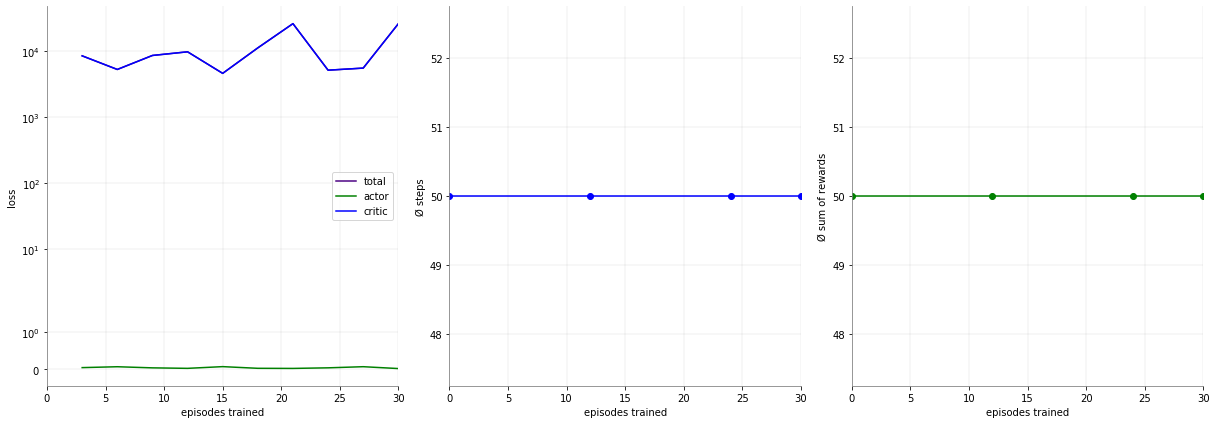

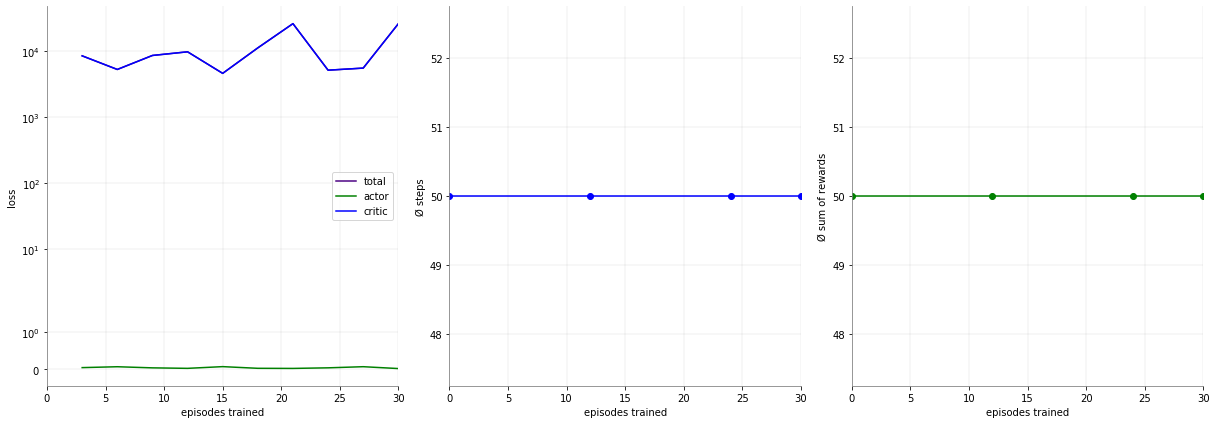

In [10]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import duration, plot

ppoAgent = PpoAgent('CartPole-v0')
ppoAgent.train([plot.Clear(on_train=False,on_play=False), duration.Fast()])

If your plot gets "doubled" after cell evaluation set on_train / on_play to True, if it disappears to False. 
Once plot.Clear() is called, the behaviour stays the same across a upcoming plots.